# Trabajo de investigacion: *Prediccion de ubicacion del delito*

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn

Datos obtenidos de: [Dataset delitos 2020 - Gobierno Buenos Aires](https://data.buenosaires.gob.ar/dataset/delitos)

In [2]:
raw_data = pd.read_csv("data/delitos_2020.csv", low_memory=False)
raw_data.head()

,dia,franja,tipo,uso_armas,barrio
0,Sábado,10,Homicidio por siniestro vial,NaN,Villa Crespo
1,Domingo,20,Homicidio por siniestro vial,NaN,Flores
2,Sábado,6,Homicidio por siniestro vial,NaN,Balvanera
3,Martes,6,Homicidio por siniestro vial,NaN,San Cristóbal
4,Martes,21,Homicidio por siniestro vial,NaN,Monserrat


## Inspeccion

Me quedo solo con los valores numericos respecto a la franja horaria del delito:

In [3]:
raw_data = raw_data[raw_data["franja"].apply(lambda x: x.isnumeric())]
raw_data.shape

raw_data["franja"] = pd.to_numeric(raw_data["franja"])

Relleno valores nulos en la columna "uso_armas" con "no":

In [4]:
raw_data["uso_armas"] = raw_data["uso_armas"].fillna("No")
print(raw_data.shape)
raw_data.head()

(66218, 5)


,dia,franja,tipo,uso_armas,barrio
0,Sábado,10,Homicidio por siniestro vial,No,Villa Crespo
1,Domingo,20,Homicidio por siniestro vial,No,Flores
2,Sábado,6,Homicidio por siniestro vial,No,Balvanera
3,Martes,6,Homicidio por siniestro vial,No,San Cristóbal
4,Martes,21,Homicidio por siniestro vial,No,Monserrat


Algunas filas tienen valores incompletos por lo que decido eliminarlas:

In [5]:
raw_data = raw_data.dropna()
raw_data.shape

(65821, 5)

Separo el target del análisis ("tipo de delito") de los datos que se utilizarán:

In [32]:
# Guardo auxiliarmente los valores de la columna "barrio"
target = raw_data["barrio"]

# Elimino la columna "tipo"
data = raw_data.drop("barrio", axis=1)
print(data.shape)
data.head()

(65821, 4)


,dia,franja,tipo,uso_armas
0,Sábado,10,Homicidio por siniestro vial,No
1,Domingo,20,Homicidio por siniestro vial,No
2,Sábado,6,Homicidio por siniestro vial,No
3,Martes,6,Homicidio por siniestro vial,No
4,Martes,21,Homicidio por siniestro vial,No


## Preparación

Transformo los datos utilizando *One Hot Encoding* en las features categoricas:

In [7]:
encoded_data = pd.get_dummies(data)
encoded_data.shape

(65821, 17)

Transformo los datos a un espacio de menores dimensiones que maximice la varianza entre los mismos:

In [8]:
from sklearn.decomposition import PCA

dimensions = encoded_data.shape[1]
pca = PCA(n_components=dimensions).fit(encoded_data)

Podemos visualizar la importancia de cada componente:

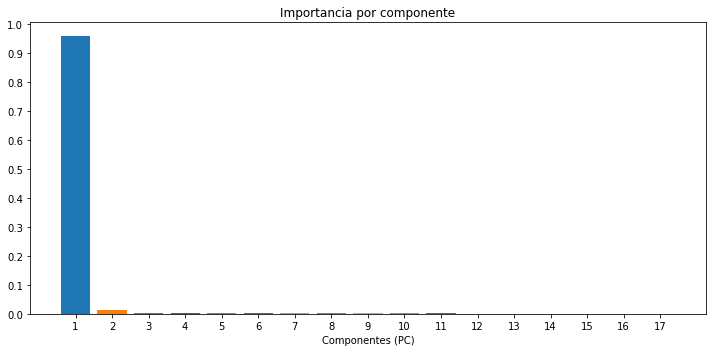

In [36]:
plt.figure(figsize=(10, 5))

width = 50
xticks = np.linspace(0, 1000, dimensions)
variances = pca.explained_variance_ratio_
xlabels = []
for n, variance in enumerate(variances, 1):
    xlabels.append(str(n))
    plt.bar(xticks[n-1], variance, width)

plt.xlabel("Componentes (PC)")
plt.xticks(xticks, xlabels)
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.title("Importancia por componente")
plt.tight_layout()
plt.show()

Y la importancia acumulada:

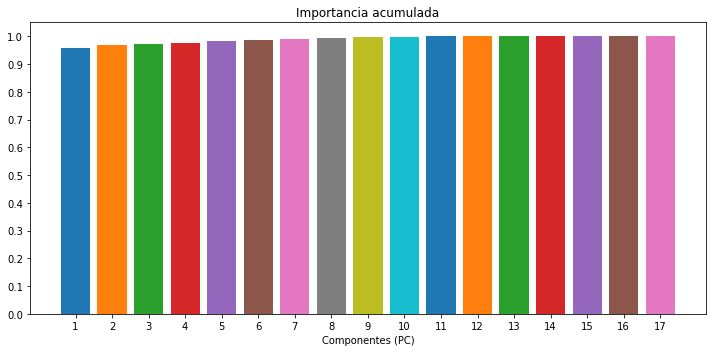

In [37]:
plt.figure(figsize=(10, 5))

width = 50
xticks = np.linspace(0, 1000, dimensions)
variances = pca.explained_variance_ratio_
xlabels = []
for n, variance in enumerate(variances, 1):
    xlabels.append(str(n))
    plt.bar(xticks[n-1], sum(variances[:n]), width)

plt.xlabel("Componentes (PC)")
plt.xticks(xticks, xlabels)
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.title("Importancia acumulada")
plt.tight_layout()
plt.show()

In [40]:
print("importancia_acumulada(8) =", sum(pca.explained_variance_ratio_[:8]) * 100, "%")

importancia_acumulada(8) = 99.25022210905807 %


- Voy a utilizar los primeros 8 componentes ya que cubren el 99% de la informacion de nuestros datos, reduciendo asi las dimensiones de 17 a 8

Transformo los datos a este nuevo espacio:

In [41]:
transformed_data = pca.transform(encoded_data)[:, :8]
transformed_data.shape

(65821, 8)

Codifico el vector target usando `LabelEncoder`:

In [42]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder().fit(target.unique())
encoded_target = encoder.transform(target.values)

Defino los datos que voy a utilizar para el entrenamiento y los de prueba para el modelo:

In [44]:
from sklearn.model_selection import train_test_split

train_size = 0.80  # Utilizo el 80% de los datos para entrenar el modelo
train_data, test_data, train_target, test_target = train_test_split(transformed_data, encoded_target, train_size=train_size, shuffle=True)
print(f"Datos de entrenamiento: {len(train_data)}")
print(f"Datos de prueba: {len(test_data)}")

Datos de entrenamiento: 52656
Datos de prueba: 13165


## Modelado

Voy a utilizar el algoritmo `KMeans` ya que conozco el numero de clusters que busco encontrar

In [45]:
classifications = target.unique()
n_classifications = len(classifications)
print(classifications, f"Total: {n_classifications}")

['Villa Crespo' 'Flores' 'Balvanera' 'San Cristóbal' 'Monserrat'
 'Villa Soldati' 'Recoleta' 'Constitución' 'Almagro' 'Parque Chas'
 'Villa Devoto' 'San Telmo' 'San Nicolás' 'Belgrano' 'Boedo'
 'Villa Lugano' 'Mataderos' 'Liniers' 'Caballito' 'Nuñez'
 'Parque Chacabuco' 'Palermo' 'Retiro' 'Villa Riachuelo'
 'Villa Del Parque' 'Chacarita' 'Floresta' 'Nueva Pompeya'
 'Parque Patricios' 'Villa Santa Rita' 'Vélez Sársfield'
 'Parque Avellaneda' 'Saavedra' 'Villa Luro' 'Paternal' 'Barracas' 'Boca'
 'Villa Urquiza' 'Villa Pueyrredón' 'Villa Gral. Mitre' 'Monte Castro'
 'Puerto Madero' 'Versalles' 'Colegiales' 'Villa Ortuzar' 'Coghlan'
 'Villa Real' 'Agronomía'] Total: 48


In [47]:
from sklearn.cluster import KMeans

classifier = KMeans(n_clusters=n_classifications, max_iter=10000, init="k-means++").fit(train_data)

## Evaluacion

In [48]:
import sklearn.metrics as metrics

predictions = classifier.predict(test_data)

score = metrics.adjusted_rand_score(predictions, test_target)
print(f"Porcentaje de coincidencia: {round(score * 100, 2)}%")

Porcentaje de coincidencia: 0.13%


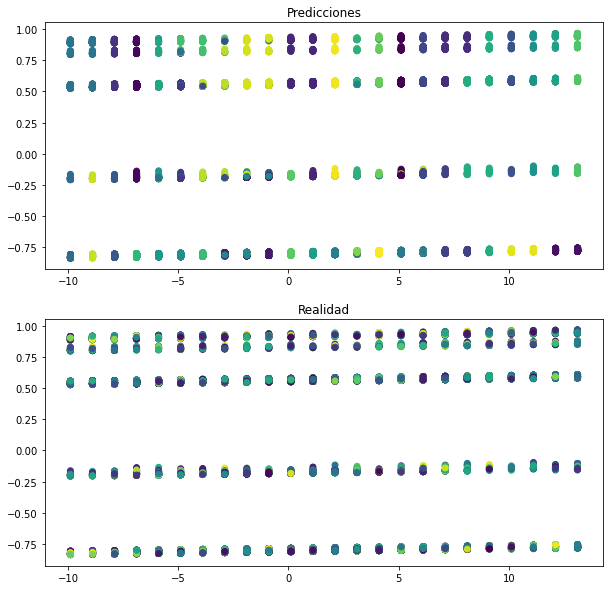

In [49]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].set_title("Predicciones")
axs[0].scatter(test_data[:, 0], test_data[:, 1], c=predictions) #test_data[:, 1]

axs[1].set_title("Realidad")
axs[1].scatter(test_data[:, 0], test_data[:, 1], c=test_target)
plt.show()

## Conclusion

El modelo no logra predecir de forma aceptable el barrio donde ocurrió el delito dados el dia la semana, la franja horaria, el tipo de delito y el uso de armas
- Esto puede ser debido a:
    - que no exista una relacion entre las caracteristicas utilizadas y el tipo de delito
    - o que cantidad de caracteristicas o datos recolectados no sea suficiente para establecer la relacion